In [43]:
pip install nilearn

In [44]:
from nilearn.datasets import fetch_haxby
from nilearn.image import index_img
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map
import pandas as pd

In [45]:
data_files = fetch_haxby(subjects=[4])
func_filenames = data_files.func[0]

In [46]:

behavioral = pd.read_csv(data_files.session_target[0], sep=" ")
mask = behavioral['labels'].isin(['rest'])
behavioral = behavioral[~mask]


In [47]:
fmri_img = index_img(func_filenames , ~mask)
masker = NiftiMasker(mask_img=data_files['mask_vt'][0])
fmri_data = masker.fit_transform(fmri_img)

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


mean Response  for category : face
mean Response  for category : house
mean Response  for category : shoe
mean Response  for category : bottle


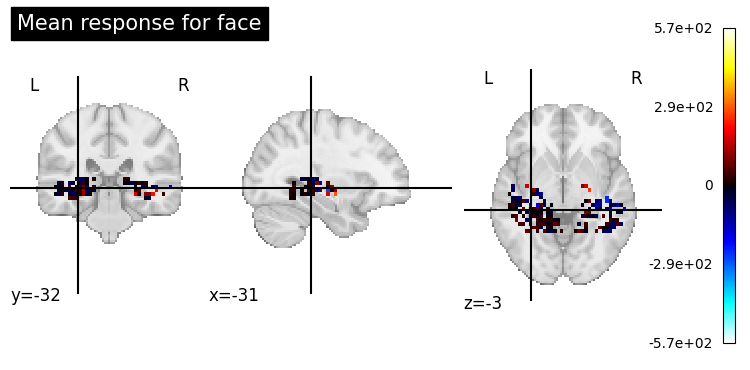

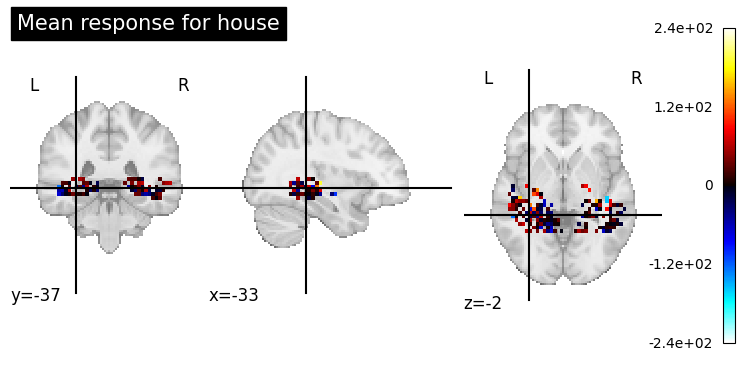

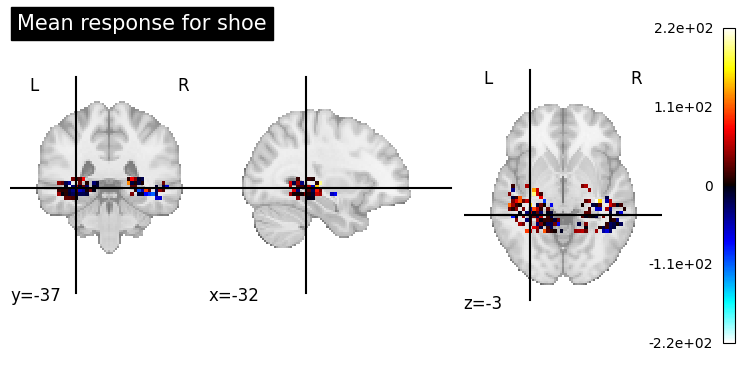

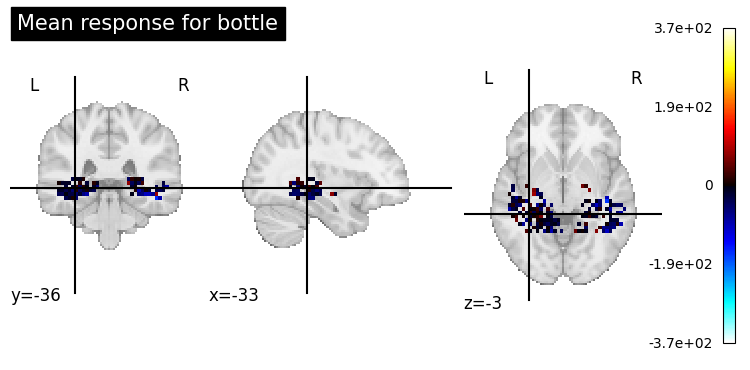

In [48]:
categorical_data = []
for label in ['face', 'house', 'shoe', 'bottle']:
  categorical_data.append(label)

compute_mean = fmri_data.mean(axis=0)
removed_mean = {}

for category in categorical_data:
    category_mask = behavioral['labels'].isin([category])
    cat_data = fmri_data[category_mask]
    removed_mean[category] = cat_data - compute_mean
    inverted_not_mean = masker.inverse_transform(removed_mean[category])


    print(f'mean Response  for category : {category}')
    if inverted_not_mean.shape[-1] !=0:
        image_3D_data = index_img(inverted_not_mean, 0)
    else:
        print(f"Error: The image does not contain any volumes. {category}")
    plot_stat_map(image_3D_data, title=f'Mean response for {category}')



In [49]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist


correlations = pd.DataFrame(index=categorical_data , columns=categorical_data )

In [50]:
for category1 in categorical_data :
    for category2 in categorical_data :
        correlation, _ = pearsonr(removed_mean[category1].mean(axis=0), removed_mean[category2].mean(axis=0))
        correlations.loc[category1, category2] = correlation

# Print correlations
print("Mean Correlations within and between category:")
print(correlations)

Mean Correlations within and between category:
            face     house      shoe    bottle
face         1.0 -0.515316 -0.350253 -0.197791
house  -0.515316       1.0  0.122589 -0.254319
shoe   -0.350253  0.122589       1.0  0.109596
bottle -0.197791 -0.254319  0.109596       1.0


face      object
house     object
shoe      object
bottle    object
dtype: object


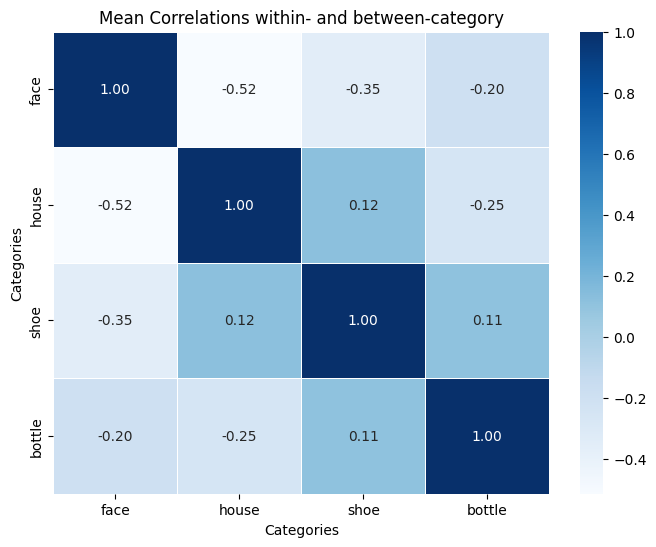

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

print(correlations.dtypes)

correlations = correlations.astype(float)
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
plt.title("Mean Correlations within- and between-category")
plt.xlabel("Categories")
plt.ylabel("Categories")
plt.show()


In [52]:
rsa_df = pd.DataFrame(index=categorical_data, columns=categorical_data)

for cat1 in categorical_data:
    for cat2 in categorical_data:
        distance = pdist([removed_mean[cat1].mean(axis=0), removed_mean[cat2].mean(axis=0)], metric='cosine')

        rsa_df.loc[cat1, cat2] = distance[0]

print("Representational Similarity Analysis between categories using Cosine distance:")
print(rsa_df)


Representational Similarity Analysis between categories using Cosine distance:
            face     house      shoe    bottle
face         0.0  1.473994  1.358236  1.174354
house   1.473994       0.0  0.799588  1.327349
shoe    1.358236  0.799588       0.0  0.934322
bottle  1.174354  1.327349  0.934322       0.0


face      object
house     object
shoe      object
bottle    object
dtype: object


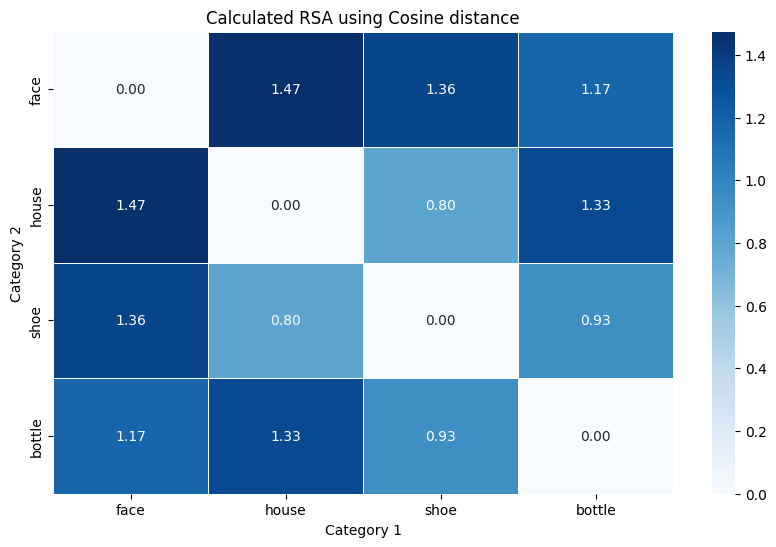

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

print(rsa_df.dtypes)

rsa_df = rsa_df.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(rsa_df, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
plt.title("Calculated RSA using Cosine distance")
plt.xlabel("Category 1")
plt.ylabel("Category 2")
plt.show()
